<a href="https://colab.research.google.com/github/Park-hanna/BDA_study/blob/main/Computer%20Vision/Dog_Breed_pertraines_keras_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""!pip install kaggle
from google.colab import files
files.upload()"""

'!pip install kaggle\nfrom google.colab import files\nfiles.upload()'

In [ ]:
#ls -1ha kaggle.json

In [ ]:
"""!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions list"""

'!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n\n!chmod 600 ~/.kaggle/kaggle.json\n\n!kaggle competitions list'

In [ ]:
#!kaggle competitions download -c dog-breed-identification

In [ ]:
#!kaggle datasets download -d gaborfodor/keras-pretrained-models

In [ ]:
# !unzip /content/dog-breed-identification.zip
# !unzip /content/keras-pretrained-models.zip

Transfer learning with pretrained Keras model
Although kernel resources were increased recently we still can not train useful CNNs without GPU. The Original imageNet set has quite a few different dog classes so we can reuse CNNs with pretrained ImageNet weights. Fortuneately prediction is much faster making it possible to run meaningful experiments

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score

import tensorflow as tf
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

In [ ]:
start = dt.datetime.now()

In [ ]:
!ls ../content/keras-pretrained-models

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Kuszma.JPG
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
cache_dir = expanduser(join('~','.keras'))
if not exists(cache_dir):
  makedirs(cache_dir)
models_dir = join(cache_dir,'models')
if not exists(models_dir):
  makedirs(models_dir)

In [ ]:
!cp /content/keras-pretrained-models/*notop* ~/.keras/models/
!cp /content/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp /content/keras-pretrained-models/resnet50* ~/.keras/models/

In [ ]:
!ls ~/.keras/models

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
!ls /content/dog-breed-identification

labels.csv  sample_submission.csv  test  train


#use to 16 classes

In [ ]:
INPUT_SIZE = 224
NUM_CLASSES= 16
SEED = 1987
data_dir = '/content/dog-breed-identification'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir,'train'))), len(labels))
print(len(listdir(join(data_dir,'test'))), len(sample_submission))

10222 10222
10357 10357


In [ ]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

<ipython-input-56-ac02b545be15>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['target'] = 1
<ipython-input-56-ac02b545be15>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['rank'] = labels.groupby('breed').rank()['id']
<ipython-input-56-ac02b545be15>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)


In [ ]:
def read_img(img_id, train_or_test, size):
  """
  # Arguments
    img_is : string
    train_or_test : string 'train' or 'test'
    size : resize the original image
  # Returns
    Image as numpy as array
  """

  img = tf.keras.utils.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
  img = tf.keras.utils.img_to_array(img)
  return img

# ResNet 50 class predictions for examples images


A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 2cb95161c43110f7111970584f804107 so we will re-download the data.
1/1 [==============================] - 0s 26ms/step


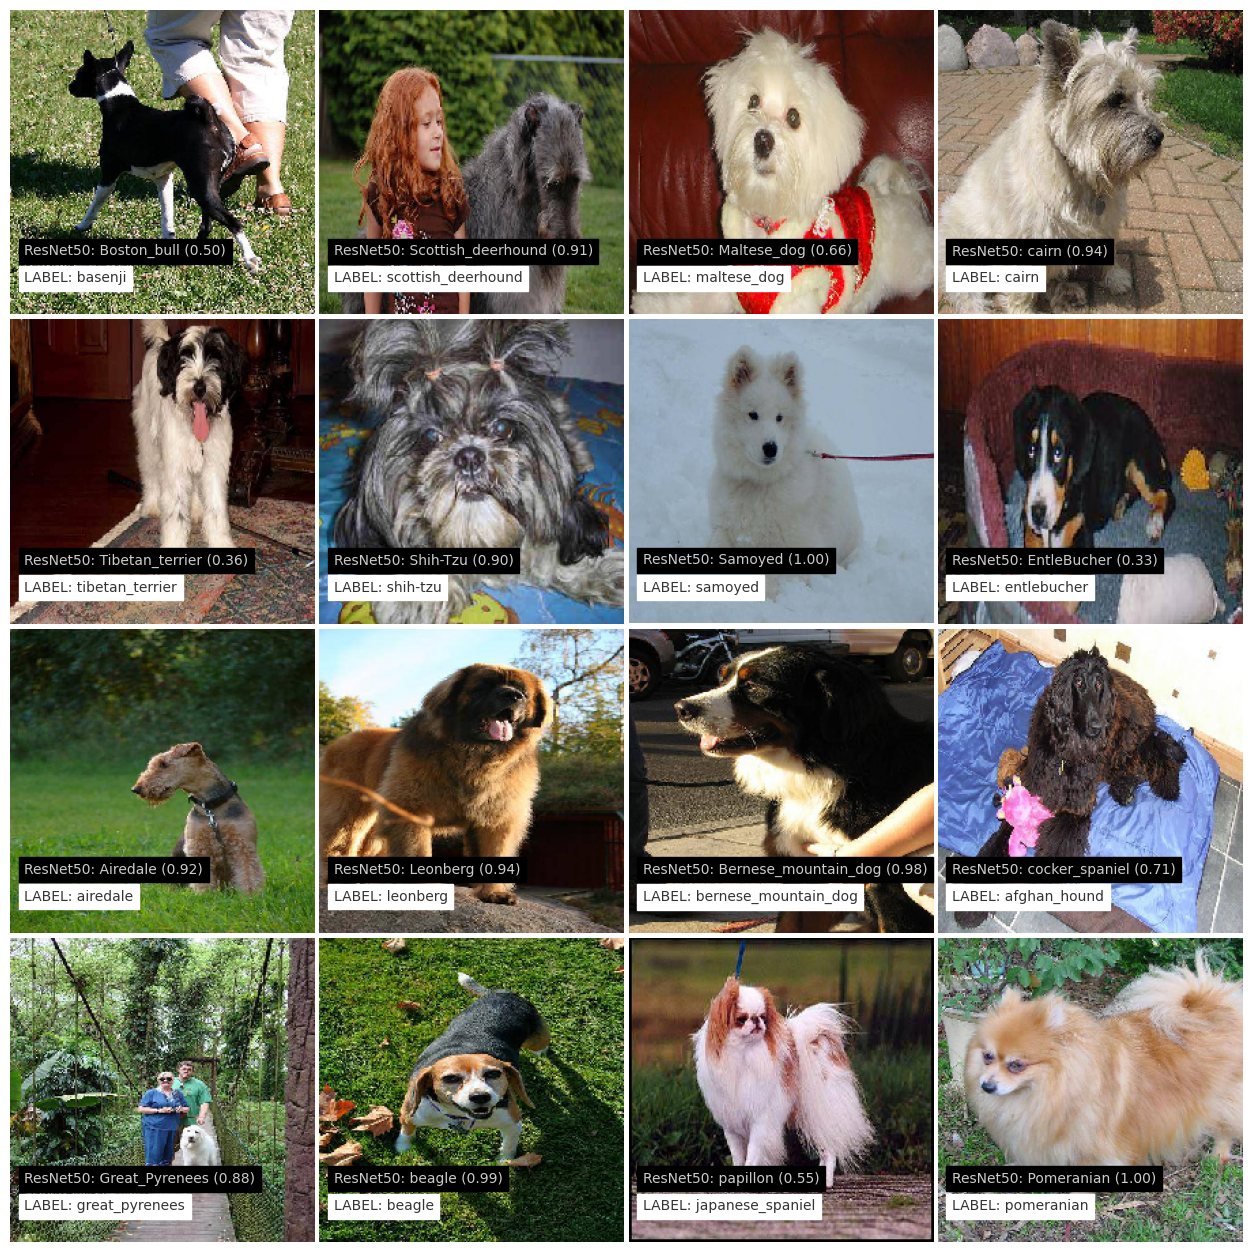

In [ ]:
model = ResNet50(weights = 'imagenet')
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize = (16,16))
grid = ImageGrid(fig, 111, nrows_ncols = (i,j), axes_pad=0.05)

for i,(img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values):
  ax = grid[i]
  img = read_img(img_id, 'train', (224, 224))
  ax.imshow(img/255.)
  x = preprocess_input(np.expand_dims(img.copy(), axis = 0))
  preds = model.predict(x)
  _, imagenet_class_name, prob = decode_predictions(preds, top =1)[0][0]
  ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name, prob), color='w', backgroundcolor = 'k', alpha=0.8)
  ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
  ax.axis('off')
plt.show()

preprocessing and prediction seems to be working.

# Extract VGG16 bottleneck features

In [ ]:
INPUT_SIZE = 224
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE , 3), dtype='float32')

for i, img_id in tqdm(enumerate(labels['id'])):
  img = read_img(img_id, 'train', (INPUT_SIZE , INPUT_SIZE))
  x = preprocess_input(np.expand_dims(img.copy(), axis = 0))
  x_train[i] = x
print('\nTrain Iamges shape : {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:09, 178.31it/s]


Train Iamges shape : (1777, 224, 224, 3) size: 267,488,256


In [ ]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
vgg_bottleneck = VGG16(weights='imagenet', include_top = False, pooling=POOLING)

train_vgg_bf = vgg_bottleneck.predict(Xtr, batch_size = 32, verbose = 1)
valid_vgg_bf = vgg_bottleneck.predict(Xv, batch_size = 32, verbose = 1)

print('VGG train bottleneck features shape : {} size : {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape : {} size : {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))

((1409, 224, 224, 3), (368, 224, 224, 3), (1409, 16), (368, 16))
12/12 [==============================] - 1s 111ms/step
VGG train bottleneck features shape : (1409, 512) size : 721,408
VGG valid bottleneck features shape : (368, 512) size : 188,416


#LogReg on VGG bottleneck features

In [ ]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state = SEED)
logreg.fit(train_vgg_bf, (ytr * range(NUM_CLASSES)).sum(axis = 1))
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print('Validation VGG LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis = 1), valid_preds)))

Validation VGG LogLoss 0.3528609943302823
Validation VGG Accuracy 0.9184782608695652


# Extract Xception bottleneck features

In [ ]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE , INPUT_SIZE , 3), dtype = 'float32')

for i, img_id in tqdm(enumerate(labels['id'])):
  img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
  x = xception.preprocess_input(np.expand_dims(img.copy(), axis = 0))
  x_train[i] = x

print('\nTrain Images shape : {} size : {:,}'.format(x_train.shape, x_train.size))

1777it [00:08, 215.69it/s]


Train Images shape : (1777, 299, 299, 3) size : 476,596,731


In [ ]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]

print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights ='imagenet', include_top=False, pooling=POOLING )
train_x_bf = xception_bottleneck.predict(Xtr, batch_size = 32, verbose = 1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size = 32, verbose = 1)

print('Xception train bottleneck features shape : {} size : {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape : {} size : {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1409, 299, 299, 3), (368, 299, 299, 3), (1409, 16), (368, 16))
12/12 [==============================] - 2s 202ms/step
Xception train bottleneck features shape : (1409, 2048) size : 2,885,632
Xception valid bottleneck features shape : (368, 2048) size : 753,664


# LogReg on Xception bottleneck features

In [ ]:
logreg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', random_state = SEED)
logreg.fit(train_x_bf, (ytr * range(NUM_CLASSES)).sum(axis = 1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)

print('Validation Xception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis =1), valid_preds)))

Validation Xception LogLoss 0.06822525585001325
Validation Xception Accuracy 0.9809782608695652


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Extract Inception bottleneck features

In [ ]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]

print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
inception_bottleneck = inception_v3.InceptionV3(weights ='imagenet', include_top=False, pooling=POOLING )
train_i_bf = inception_bottleneck.predict(Xtr, batch_size = 32, verbose = 1)
valid_i_bf = inception_bottleneck.predict(Xv, batch_size = 32, verbose = 1)

print('Inception train bottleneck features shape : {} size : {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Inception valid bottleneck features shape : {} size : {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1409, 299, 299, 3), (368, 299, 299, 3), (1409, 16), (368, 16))
12/12 [==============================] - 1s 103ms/step
Inception train bottleneck features shape : (1409, 2048) size : 2,885,632
Inception valid bottleneck features shape : (368, 2048) size : 753,664


# LogReg on Inception bottleneck features

In [ ]:
logreg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', random_state = SEED)
logreg.fit(train_i_bf, (ytr * range(NUM_CLASSES)).sum(axis = 1))
valid_probs = logreg.predict_proba(valid_i_bf)
valid_preds = logreg.predict(valid_i_bf)

print('Validation Xception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis =1), valid_preds)))

Validation Xception LogLoss 0.08074001836633699
Validation Xception Accuracy 0.967391304347826


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# LogReg on all bottleneck features

In [ ]:
X = np.hstack([train_x_bf, train_i_bf])
V = np.hstack([valid_x_bf, valid_i_bf])
print('Full train bottleneck features shape : {} size : {:,}'.format(X.shape, X.size))
print('Full valid bottleneck features shape : {} size : {:,}'.format(V.shape, V.size))

logreg = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', random_state = SEED)
logreg.fit(X, (ytr * range(NUM_CLASSES)).sum(axis =1))
valid_probs = logreg.predict_proba(V)
valid_preds = logreg.predict(V)

print('Validation Xception + Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception + Inception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Full train bottleneck features shape : (1409, 4096) size : 5,771,264
Full valid bottleneck features shape : (368, 4096) size : 1,507,328
Validation Xception + Inception LogLoss 0.07089148432111028
Validation Xception + Inception Accuracy 0.9755434782608695


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Check Errors

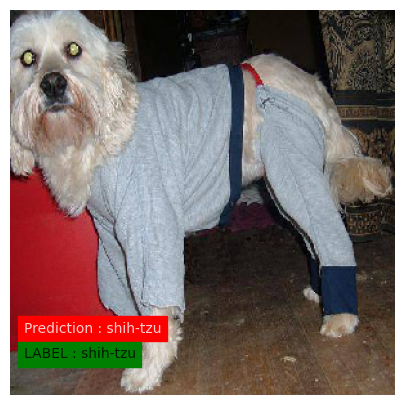

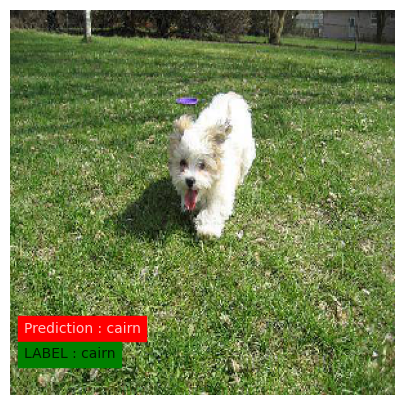

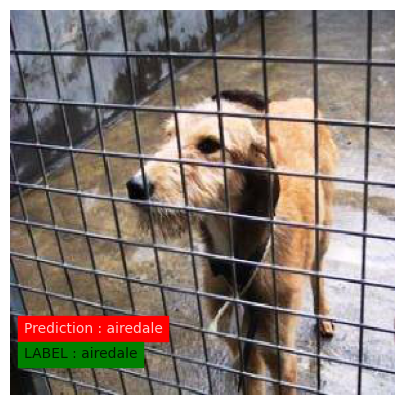

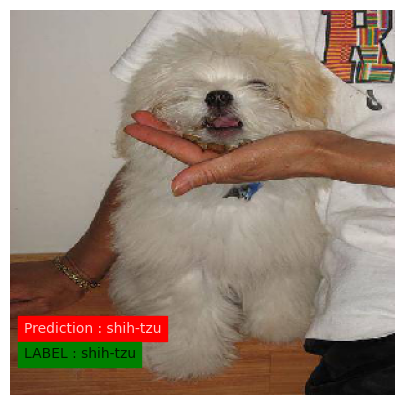

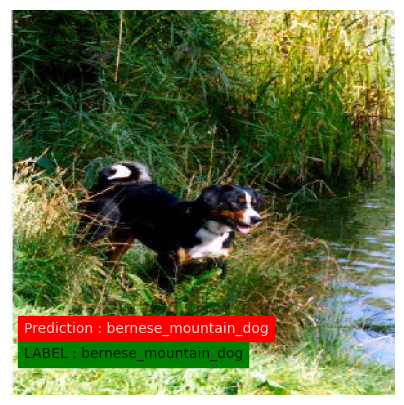

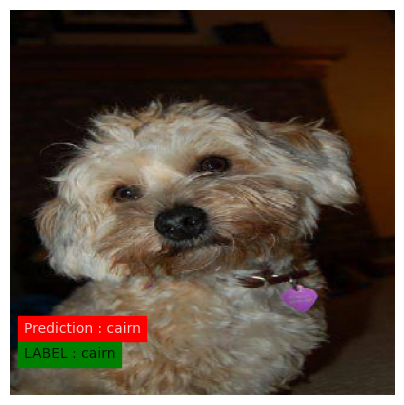

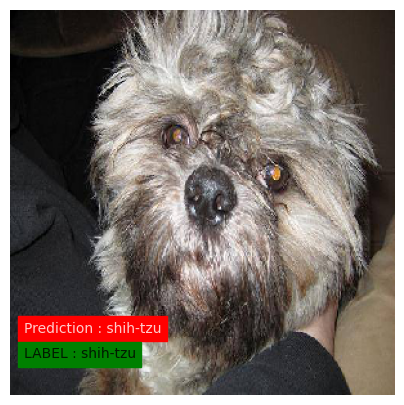

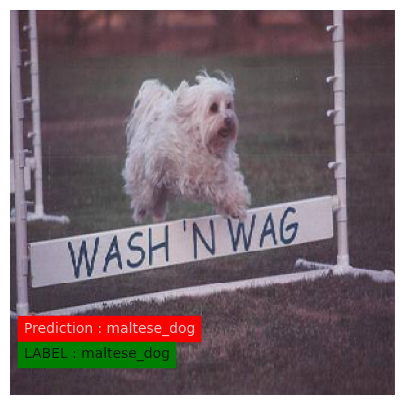

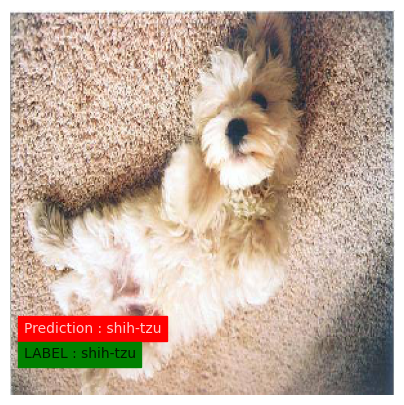

In [ ]:
valid_breeds = (yv * range(NUM_CLASSES)).sum(axis = 1)
error_idx = (valid_breeds != valid_preds)
for img_id, breed, pred in zip(labels.loc[valid_idx, 'id'].values[error_idx],
                               [selected_breed_list[int(b)] for b in valid_preds[error_idx]],
                               [selected_breed_list[int(b)] for b in valid_preds[error_idx]]):
  fig, ax = plt.subplots(figsize = (5,5))
  img = read_img(img_id, 'train', (299, 299))
  ax.imshow(img/255.)
  ax.text(10, 250, 'Prediction : %s' % pred, color = 'w', backgroundcolor = 'r', alpha = 0.8)
  ax.text(10, 270, 'LABEL : %s' % breed, color = 'k', backgroundcolor = 'g', alpha = 0.8)
  ax.axis('off')
  plt.show()

In [ ]:
end = dt.datetime.now()
print('Total time {}s.'.format((end-start).seconds))
print('We almost used the one hour time limit.')

Total time 106s.
We almost used the one hour time limit.
